In [1]:
import pickle
import csv
import pathlib
import os
from collections import defaultdict
import zipfile

from tqdm import tqdm
import numpy as np

In [69]:
root_d = pathlib.Path('emage_amass30_beat2')
amass_d = root_d / 'amass_smplx'
beat2_d = root_d / 'beat_v2.0.0'
data_d = root_d / 'emage_amass30_beat2'

data_d.mkdir(parents=True,exist_ok=True)

Subset of AMASS that has fps multiple of 30.

In [70]:
data_fs = [pathlib.Path(f'{rt}/{f}')
           for rt,ds,fs in os.walk(amass_d)
           for f in fs
           if f.endswith('.npz')]
data_fs.sort()

In [71]:
amass_data_fs = list()
files_not_readable = list()
files_model_type_not_usable = list()
files_mocap_frame_rate_key_missing = list()
files_frame_rate_not_multiple_of_30 = list()
all_model_types = defaultdict(int)
all_fps = defaultdict(int)
for f in tqdm(data_fs,desc='filtering 30fps files',ncols=150):
    try:
        data = np.load(f,allow_pickle=True)
    except zipfile.BadZipFile:
        files_not_readable.append(f)
        continue
    all_model_types[data['surface_model_type'].item()] += 1
    if data['surface_model_type'].item() not in {'smplx','smplx_locked_head'}:
        files_model_type_not_usable.append(f)
        continue
    if 'mocap_frame_rate' not in data:
        files_mocap_frame_rate_key_missing.append(f)
        continue
    fps = int(data['mocap_frame_rate'].item())
    all_fps[fps] += 1
    if fps % 30 != 0:
        files_frame_rate_not_multiple_of_30.append(f)
        continue
    amass_data_fs.append(f)
print('total files:',len(data_fs))
print('usable_files:',len(amass_data_fs))
print('files not readable:',len(files_not_readable))
print('files model type not usable:',len(files_model_type_not_usable))
print('files missing mocap_frame_rate:',len(files_mocap_frame_rate_key_missing))
print('files with frame rante not multiple of 30fps:',len(files_frame_rate_not_multiple_of_30))
print('model types:',*sorted(all_model_types.items()))
print('mocap frame rate:',*sorted(all_fps.items()))
assert len(data_fs) == (len(amass_data_fs) + 
                        len(files_not_readable) + 
                        len(files_model_type_not_usable) + 
                        len(files_mocap_frame_rate_key_missing) + 
                        len(files_frame_rate_not_multiple_of_30))

filtering 30fps files: 0it [00:00, ?it/s]

total files: 0
usable_files: 0
files not readable: 0
files model type not usable: 0
files missing mocap_frame_rate: 0
files with frame rante not multiple of 30fps: 0
model types:
mocap frame rate:


Number of usable files is 9977. Create symlinks to these files in the combined data dir. EMAGE code was written for BEAT2 which has all the npz files at the top level. Create the same structure here.

In [72]:
for src_f in tqdm(amass_data_fs,desc='creating symlinks',ncols=150):
    dst_f = data_d / str(src_f.relative_to(amass_d)).replace('/','__')
    dst_f.symlink_to(src_f)

creating symlinks: 0it [00:00, ?it/s]


Create symlinks to BEAT2 files in the combined data dir. There is no filtering needed for BEAT2 as all of them are 30fps already.

In [73]:
beat2_data_fs = [pathlib.Path(f'{rt}/{f}')
                 for rt,ds,fs in os.walk(beat2_d)
                 for f in fs
                 if f.endswith('.npz')]
beat2_data_fs.sort()

for src_f in tqdm(beat2_data_fs,desc='creating symlinks',ncols=150):
    dst_f = data_d / str(src_f.relative_to(beat2_d)).replace('/','__')
    dst_f.symlink_to(src_f)

creating symlinks: 0it [00:00, ?it/s]


Make sure there are correct number of files in the data dir. Total should be `9977+2048=12025`.

In [74]:
data_fs = list(data_d.iterdir())
data_fs.sort()

print('num files:',len(data_fs))

num files: 0


Create the train/val/test split file similar to BEAT2 because EMAGE code expects it. Here we will use the following:
* train = AMASS30 + BEAT2-train + BEAT2-val + BEAT2-additional
* val = BEAT2-test
* test = BEAT2-test

In [75]:
train_val_test = defaultdict(list)
for train_val_test_f in beat2_d.glob('*/train_test_split.csv'):
    for row in csv.DictReader(open(train_val_test_f)):
        train_val_test[row['type']].append((train_val_test_f.parent.name,
                                            row['id']))

for k,v in train_val_test.items():
    print(f'num examples BEAT2 {k}:',len(v))

In [76]:
rows = list()

missing_files = list()
added_files = set()

n_test = 0
n_val = 0
for d,i in train_val_test['test']:
    id = f'{d}__smplxflame_30__{i}'
    f = data_d / f'{id}.npz'
    if not f.is_file():
        missing_files.append(f)
        continue
    rows.append({'id':id,
                 'type':'test'})
    rows.append({'id':id,
                 'type':'val'})
    n_test += 1
    n_val += 1
    added_files.add(f)
    
n_train = 0
for d,i in (train_val_test['train'] + 
            train_val_test['val'] + 
            train_val_test['additional']):
    id = f'{d}__smplxflame_30__{i}'
    f = data_d / f'{id}.npz'
    if not f.is_file():
        missing_files.append(f)
        continue
    rows.append({'id':id,
                 'type':'train'})
    n_train += 1
    added_files.add(f)
    
for f in data_fs:
    if f in added_files:
        continue
    rows.append({'id':f.with_suffix('').name,
                 'type':'train'})
    n_train += 1
    
print('num examples:',len(rows))
print('num train:',n_train)
print('num train:',n_val)
print('num test:',n_test)
print('missing files:',len(missing_files))

num examples: 0
num train: 0
num train: 0
num test: 0
missing files: 0


Missing files do not affect us. Moving on to write the csv.

In [77]:
csv_f = data_d / 'train_test_split.csv'
with open(csv_f,'w') as csv_fh:
    writer = csv.DictWriter(csv_fh,
                            fieldnames=['id','type'])
    writer.writeheader()
    writer.writerows(rows)

Move all the npz files to a sub-dir named `smplxflame_30`. EMAGE expects this structure.

In [78]:
!mkdir emage_amass30_beat2/smplxflame_30
!mv emage_amass30_beat2/*.npz emage_amass30_beat2/smplxflame_30
!mkdir emage_amass30_beat2/weights


EnvironmentNameNotFound: Could not find conda environment: avjoint
You can list all discoverable environments with `conda info --envs`.


mkdir: cannot create directory ‘emage_amass30_beat2/smplxflame_30’: File exists
^C

EnvironmentNameNotFound: Could not find conda environment: avjoint
You can list all discoverable environments with `conda info --envs`.


mkdir: cannot create directory ‘emage_amass30_beat2/weights’: File exists


# Scratch 

In [2]:
import pickle
import pathlib

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted

sns.set(font_scale=2)
sns.set_theme(style='white')
plt_px = 1/plt.rcParams['figure.dpi']

In [2]:
scores_f = pathlib.Path('test_scores_pt.pkl')
scores = pickle.load(open(scores_f,'rb'))

In [ ]:
id,rec,ver,com,sp_id,sp_name = list(),list(),list(),list(),list(),list()
for k,v in scores.items():
    id.append(k)
    rec.append(v['rec'])
    ver.append(v['ver'])
    com.append(v['com'])
    k = k.replace('beat_chinese_v2.0.0__smplxflame_30__','')
    k = k.replace('beat_english_v2.0.0__smplxflame_30__','')
    k = k.replace('beat_japanese_v2.0.0__smplxflame_30__','')
    k = k.replace('beat_spanish_v2.0.0__smplxflame_30__','')
    i,n = k.split('_')[:2]
    sp_id.append(f'{i}_{n}')

df = pd.DataFrame({'id':id,
                   'rec':rec,
                   'ver':ver,
                   'com':com,
                   'sp_id':sp_id})
df

,id,rec,ver,com,sp_id
0,beat_chinese_v2.0.0__smplxflame_30__12_zhao_2_1_1,0.218987,0.003080,0.680495,12_zhao
1,beat_chinese_v2.0.0__smplxflame_30__12_zhao_2_2_2,0.216144,0.003030,0.688222,12_zhao
2,beat_chinese_v2.0.0__smplxflame_30__12_zhao_2_3_3,0.209789,0.003216,0.694088,12_zhao
3,beat_chinese_v2.0.0__smplxflame_30__12_zhao_2_4_4,0.215658,0.003102,0.660892,12_zhao
4,beat_chinese_v2.0.0__smplxflame_30__12_zhao_2_5_5,0.222634,0.003207,0.768505,12_zhao
...,...,...,...,...,...
350,beat_spanish_v2.0.0__smplxflame_30__16_jorge_4...,0.175428,0.003004,0.483337,16_jorge
351,beat_spanish_v2.0.0__smplxflame_30__16_jorge_4...,0.162666,0.002747,0.529702,16_jorge
352,beat_spanish_v2.0.0__smplxflame_30__16_jorge_4...,0.197013,0.003126,0.594691,16_jorge
353,beat_spanish_v2.0.0__smplxflame_30__16_jorge_4...,0.156205,0.002929,0.427787,16_jorge


In [4]:
ids = natsorted(df.sp_id.unique().tolist())
print('num speakers:',len(ids))

num speakers: 25


In [5]:
ids

['1_wayne',
 '2_scott',
 '3_solomon',
 '4_lawrence',
 '5_stewart',
 '6_carla',
 '7_sophie',
 '9_miranda',
 '10_kieks',
 '11_nidal',
 '12_zhao',
 '13_lu',
 '15_carlos',
 '16_jorge',
 '17_itoi',
 '18_daiki',
 '20_li',
 '21_ayana',
 '22_luqi',
 '23_hailing',
 '24_kexin',
 '25_goto',
 '27_yingqing',
 '28_tiffnay',
 '30_katya']

In [6]:
df['size'] = (df.sp_id == '2_scott')*1 + 1
df

,id,rec,ver,com,sp_id,size
0,beat_chinese_v2.0.0__smplxflame_30__12_zhao_2_1_1,0.218987,0.003080,0.680495,12_zhao,1
1,beat_chinese_v2.0.0__smplxflame_30__12_zhao_2_2_2,0.216144,0.003030,0.688222,12_zhao,1
2,beat_chinese_v2.0.0__smplxflame_30__12_zhao_2_3_3,0.209789,0.003216,0.694088,12_zhao,1
3,beat_chinese_v2.0.0__smplxflame_30__12_zhao_2_4_4,0.215658,0.003102,0.660892,12_zhao,1
4,beat_chinese_v2.0.0__smplxflame_30__12_zhao_2_5_5,0.222634,0.003207,0.768505,12_zhao,1
...,...,...,...,...,...,...
350,beat_spanish_v2.0.0__smplxflame_30__16_jorge_4...,0.175428,0.003004,0.483337,16_jorge,1
351,beat_spanish_v2.0.0__smplxflame_30__16_jorge_4...,0.162666,0.002747,0.529702,16_jorge,1
352,beat_spanish_v2.0.0__smplxflame_30__16_jorge_4...,0.197013,0.003126,0.594691,16_jorge,1
353,beat_spanish_v2.0.0__smplxflame_30__16_jorge_4...,0.156205,0.002929,0.427787,16_jorge,1


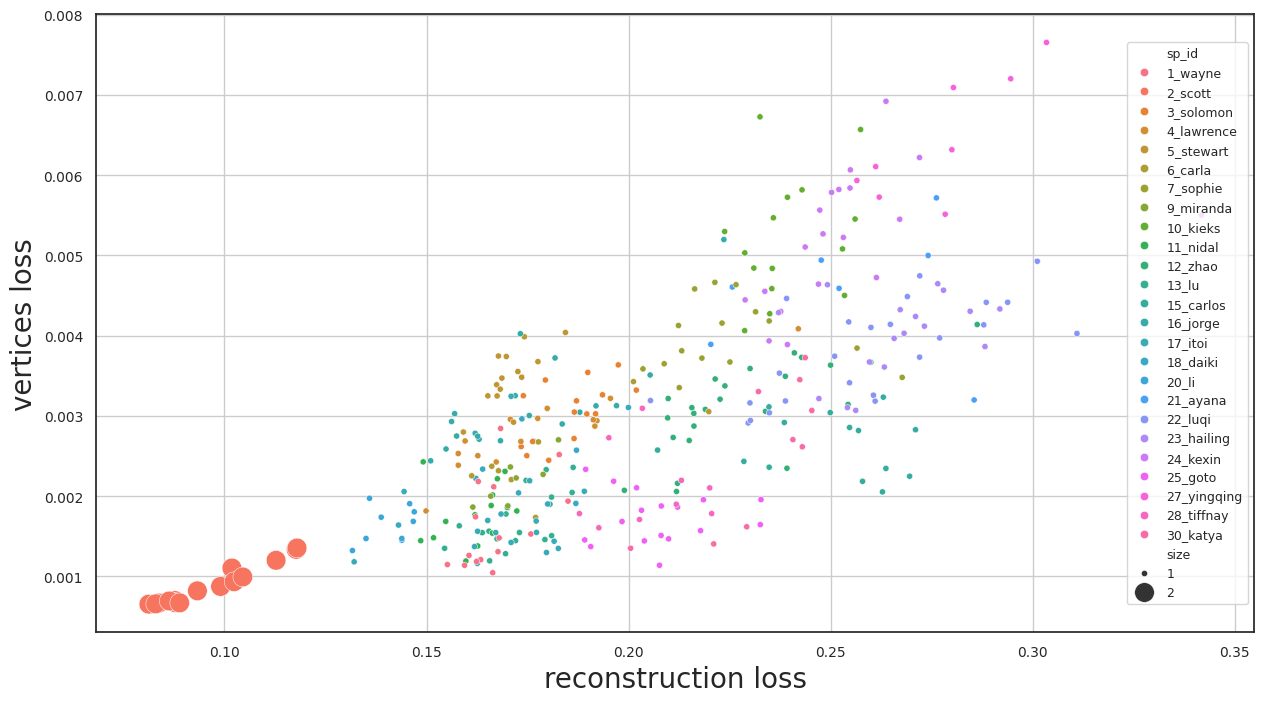

In [21]:
fig = plt.figure(figsize=(1280*plt_px,720*plt_px))
ax = sns.scatterplot(data=df,x='rec',y='ver',hue='sp_id',hue_order=ids,size='size',sizes=(20,200))
plt.xlabel('reconstruction loss',fontsize=20)
plt.ylabel('vertices loss',fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='right',fontsize=9)
plt.grid()
plt.tight_layout()

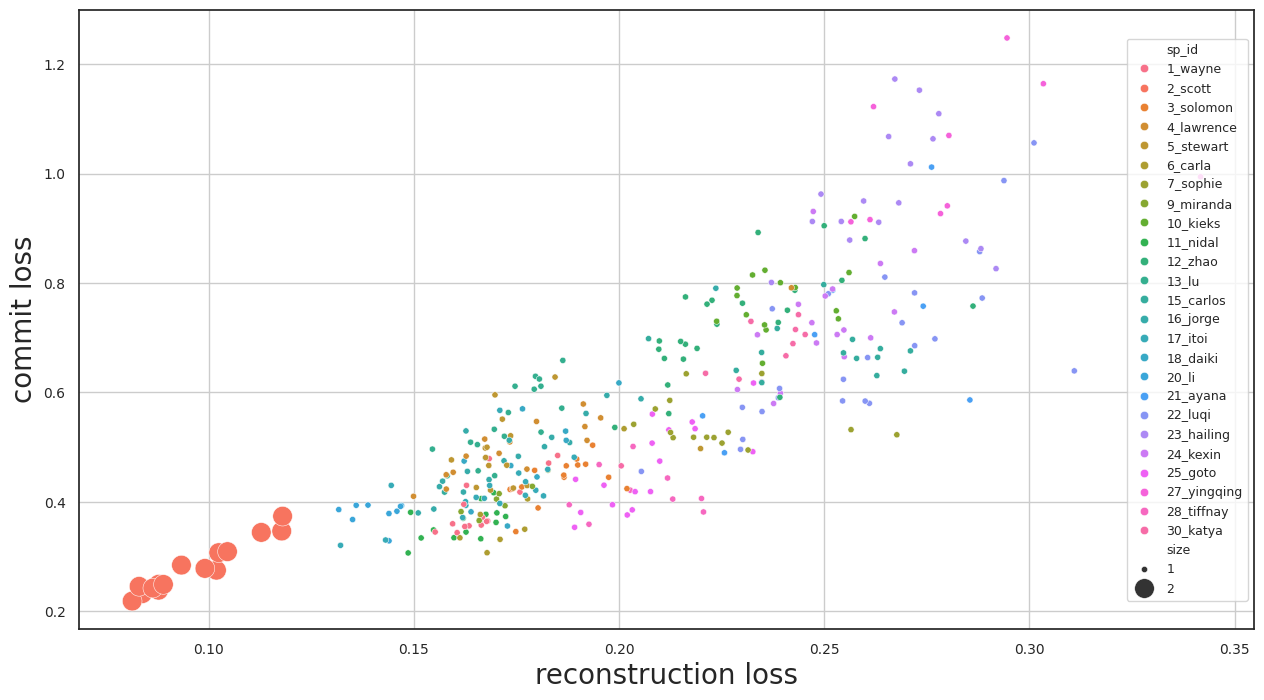

In [23]:
fig = plt.figure(figsize=(1280*plt_px,720*plt_px))
ax = sns.scatterplot(data=df,x='rec',y='com',hue='sp_id',hue_order=ids,size='size',sizes=(20,200))
plt.xlabel('reconstruction loss',fontsize=20)
plt.ylabel('commit loss',fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='right',fontsize=9)
plt.grid()
plt.tight_layout()

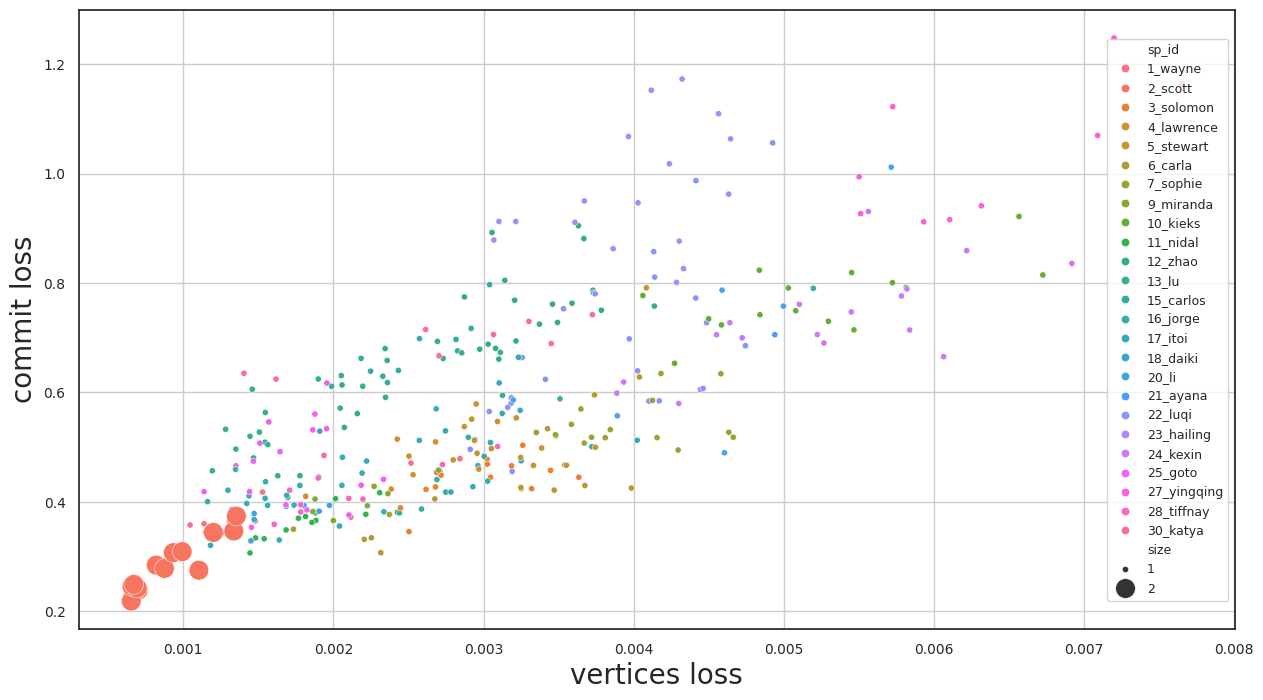

In [24]:
fig = plt.figure(figsize=(1280*plt_px,720*plt_px))
ax = sns.scatterplot(data=df,x='ver',y='com',hue='sp_id',hue_order=ids,size='size',sizes=(20,200))
plt.xlabel('vertices loss',fontsize=20)
plt.ylabel('commit loss',fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='right',fontsize=9)
plt.grid()
plt.tight_layout()

In [25]:
scores_f = pathlib.Path('test_scores_epoch_0005_iter_012000.pkl')
scores = pickle.load(open(scores_f,'rb'))

In [26]:
id,rec,ver,com,sp_id,sp_name = list(),list(),list(),list(),list(),list()
for k,v in scores.items():
    id.append(k)
    rec.append(v['rec'])
    ver.append(v['ver'])
    com.append(v['com'])
    k = k.replace('beat_chinese_v2.0.0__smplxflame_30__','')
    k = k.replace('beat_english_v2.0.0__smplxflame_30__','')
    k = k.replace('beat_japanese_v2.0.0__smplxflame_30__','')
    k = k.replace('beat_spanish_v2.0.0__smplxflame_30__','')
    i,n = k.split('_')[:2]
    sp_id.append(f'{i}_{n}')

df = pd.DataFrame({'id':id,
                   'rec':rec,
                   'ver':ver,
                   'com':com,
                   'sp_id':sp_id})
df

,id,rec,ver,com,sp_id
0,beat_chinese_v2.0.0__smplxflame_30__12_zhao_2_1_1,0.165104,0.002772,0.164020,12_zhao
1,beat_chinese_v2.0.0__smplxflame_30__12_zhao_2_2_2,0.163562,0.002106,0.163165,12_zhao
2,beat_chinese_v2.0.0__smplxflame_30__12_zhao_2_3_3,0.161991,0.002225,0.167626,12_zhao
3,beat_chinese_v2.0.0__smplxflame_30__12_zhao_2_4_4,0.154241,0.002044,0.163029,12_zhao
4,beat_chinese_v2.0.0__smplxflame_30__12_zhao_2_5_5,0.168925,0.002226,0.177764,12_zhao
...,...,...,...,...,...
350,beat_spanish_v2.0.0__smplxflame_30__16_jorge_4...,0.146081,0.001843,0.148630,16_jorge
351,beat_spanish_v2.0.0__smplxflame_30__16_jorge_4...,0.133190,0.002426,0.148906,16_jorge
352,beat_spanish_v2.0.0__smplxflame_30__16_jorge_4...,0.164139,0.001591,0.157534,16_jorge
353,beat_spanish_v2.0.0__smplxflame_30__16_jorge_4...,0.118553,0.001441,0.111826,16_jorge


In [27]:
ids = natsorted(df.sp_id.unique().tolist())
print('num speakers:',len(ids))

num speakers: 25


In [28]:
df['size'] = (df.sp_id == '2_scott')*1 + 1
df

,id,rec,ver,com,sp_id,size
0,beat_chinese_v2.0.0__smplxflame_30__12_zhao_2_1_1,0.165104,0.002772,0.164020,12_zhao,1
1,beat_chinese_v2.0.0__smplxflame_30__12_zhao_2_2_2,0.163562,0.002106,0.163165,12_zhao,1
2,beat_chinese_v2.0.0__smplxflame_30__12_zhao_2_3_3,0.161991,0.002225,0.167626,12_zhao,1
3,beat_chinese_v2.0.0__smplxflame_30__12_zhao_2_4_4,0.154241,0.002044,0.163029,12_zhao,1
4,beat_chinese_v2.0.0__smplxflame_30__12_zhao_2_5_5,0.168925,0.002226,0.177764,12_zhao,1
...,...,...,...,...,...,...
350,beat_spanish_v2.0.0__smplxflame_30__16_jorge_4...,0.146081,0.001843,0.148630,16_jorge,1
351,beat_spanish_v2.0.0__smplxflame_30__16_jorge_4...,0.133190,0.002426,0.148906,16_jorge,1
352,beat_spanish_v2.0.0__smplxflame_30__16_jorge_4...,0.164139,0.001591,0.157534,16_jorge,1
353,beat_spanish_v2.0.0__smplxflame_30__16_jorge_4...,0.118553,0.001441,0.111826,16_jorge,1


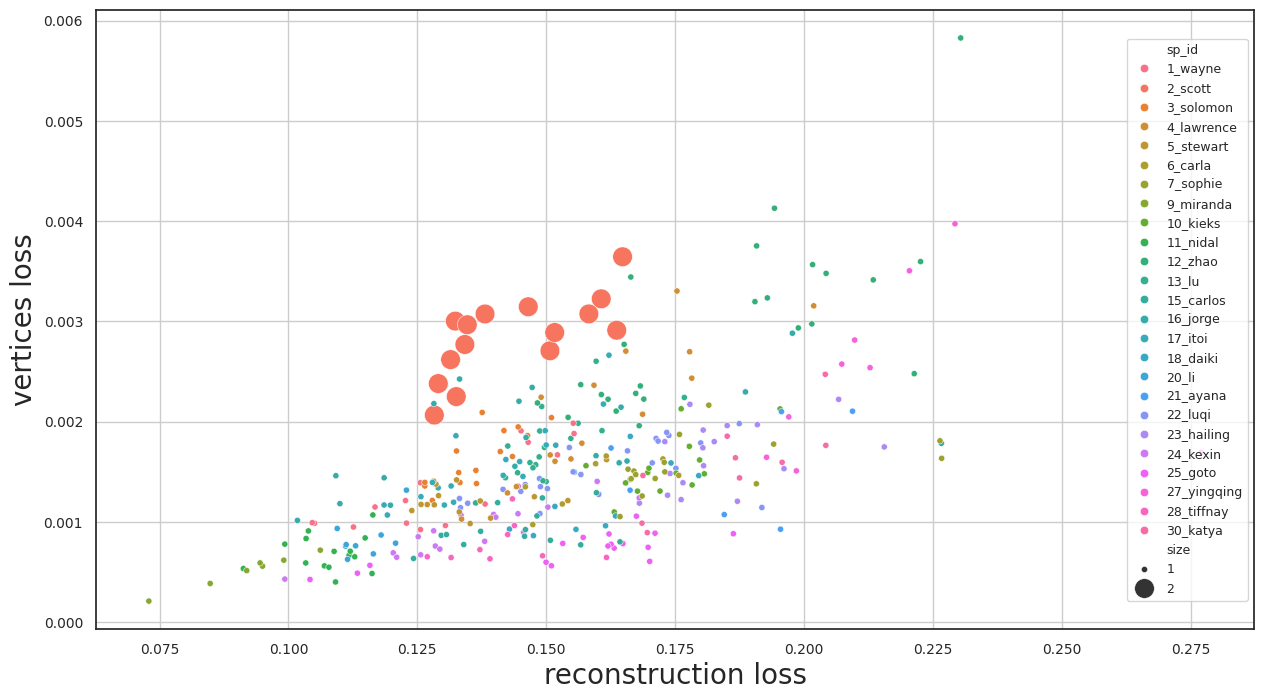

In [30]:
fig = plt.figure(figsize=(1280*plt_px,720*plt_px))
ax = sns.scatterplot(data=df,x='rec',y='ver',hue='sp_id',hue_order=ids,size='size',sizes=(20,200))
plt.xlabel('reconstruction loss',fontsize=20)
plt.ylabel('vertices loss',fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='right',fontsize=9)
plt.grid()
plt.tight_layout()

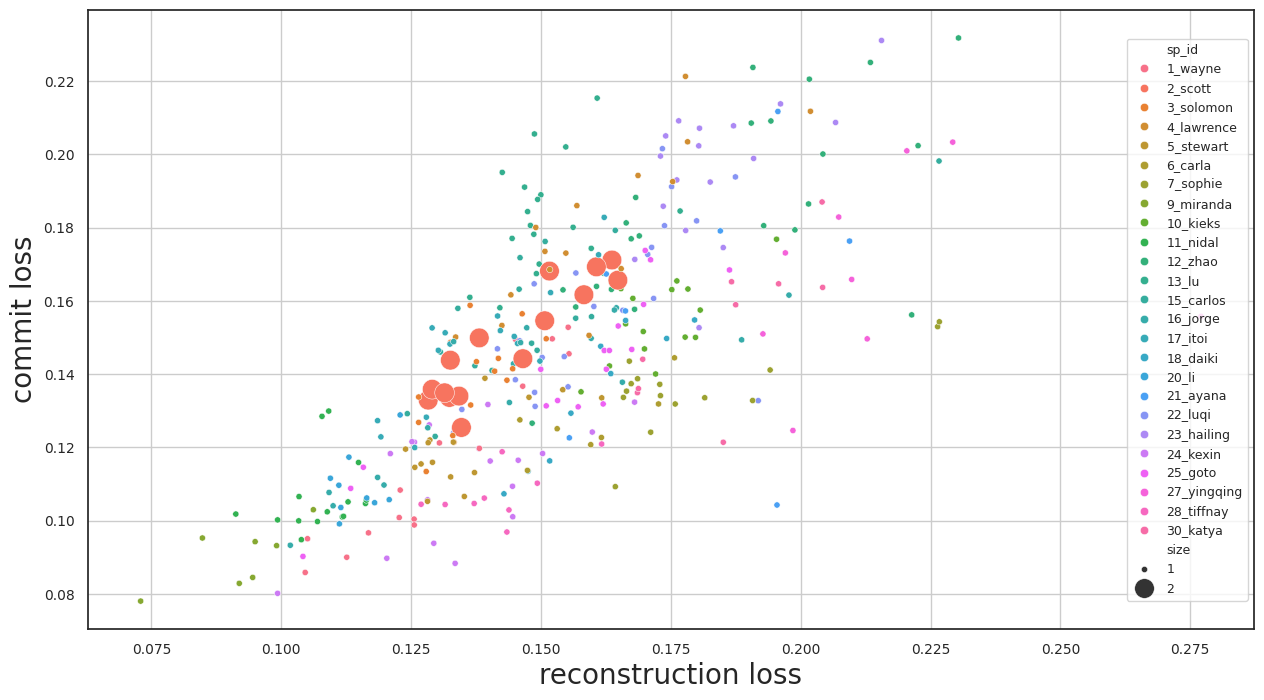

In [31]:
fig = plt.figure(figsize=(1280*plt_px,720*plt_px))
ax = sns.scatterplot(data=df,x='rec',y='com',hue='sp_id',hue_order=ids,size='size',sizes=(20,200))
plt.xlabel('reconstruction loss',fontsize=20)
plt.ylabel('commit loss',fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='right',fontsize=9)
plt.grid()
plt.tight_layout()

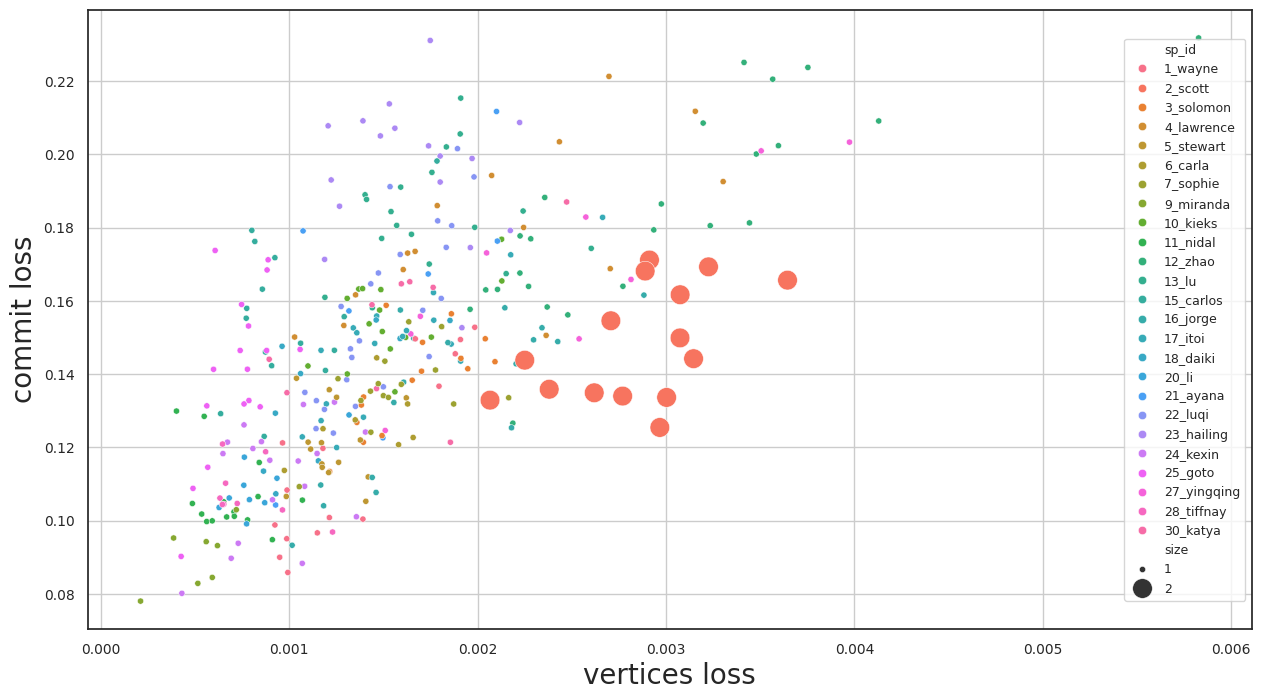

In [32]:
fig = plt.figure(figsize=(1280*plt_px,720*plt_px))
ax = sns.scatterplot(data=df,x='ver',y='com',hue='sp_id',hue_order=ids,size='size',sizes=(20,200))
plt.xlabel('vertices loss',fontsize=20)
plt.ylabel('commit loss',fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='right',fontsize=9)
plt.grid()
plt.tight_layout()

Make plots of test losses comparing training only on BEAT2 vs training on BEAT2+AMASS30.

In [39]:
test_losses_d = pathlib.Path('test_losses')
lower_b2 = next(test_losses_d.glob('lower_b2ss_*'))
upper_b2 = next(test_losses_d.glob('upper_b2ss_*'))
hands_b2 = next(test_losses_d.glob('hands_b2ss_*'))
lower_a30b2 = next(test_losses_d.glob('lower_a30b2ss_*'))
upper_a30b2 = next(test_losses_d.glob('lower_a30b2ss_*'))
hands_a30b2 = next(test_losses_d.glob('lower_a30b2ss_*'))

In [40]:
lower_b2_losses = [pickle.load(open(f,'rb'))
                   for f in sorted(lower_b2.iterdir())]
upper_b2_losses = [pickle.load(open(f,'rb'))
                   for f in sorted(upper_b2.iterdir())]
hands_b2_losses = [pickle.load(open(f,'rb'))
                   for f in sorted(hands_b2.iterdir())]
lower_a30b2_losses = [pickle.load(open(f,'rb'))
                      for f in sorted(lower_a30b2.iterdir())]
upper_a30b2_losses = [pickle.load(open(f,'rb'))
                      for f in sorted(upper_a30b2.iterdir())]
hands_a30b2_losses = [pickle.load(open(f,'rb'))
                      for f in sorted(hands_a30b2.iterdir())]

In [41]:
def create_rows(losses,part,dataset):
    rows = list()
    for epoch,row in enumerate(losses):
        for seq,values in row.items():
            rows.append({'part':part,
                         'dataset':dataset,
                         'epoch':epoch,
                         'seq':seq,
                         'rec':values['rec'],
                         'ver':values['ver']})    
    return rows

In [42]:
df = (create_rows(lower_b2_losses,'lower','b2') +
      create_rows(upper_b2_losses,'upper','b2') +
      create_rows(hands_b2_losses,'hands','b2') +
      create_rows(lower_a30b2_losses,'lower','a30b2') +
      create_rows(lower_a30b2_losses,'upper','a30b2') +
      create_rows(lower_a30b2_losses,'hands','a30b2'))
df = pd.DataFrame(df)
# Remove the rows for epoch 0 because these errors are computing at the first
# iter of the training. 
df = df[df.epoch > 0]
df

,part,dataset,epoch,seq,rec,ver
130,lower,b2,1,beat_english_v2.0.0__smplxflame_30__2_scott_0_...,0.198805,0.002833
131,lower,b2,1,beat_english_v2.0.0__smplxflame_30__2_scott_0_...,0.196994,0.003577
132,lower,b2,1,beat_english_v2.0.0__smplxflame_30__2_scott_0_...,0.182251,0.003432
133,lower,b2,1,beat_english_v2.0.0__smplxflame_30__2_scott_0_...,0.169218,0.003413
134,lower,b2,1,beat_english_v2.0.0__smplxflame_30__2_scott_0_...,0.175652,0.003122
...,...,...,...,...,...,...
69415,hands,a30b2,88,beat_english_v2.0.0__smplxflame_30__2_scott_0_...,0.113430,0.001000
69416,hands,a30b2,88,beat_english_v2.0.0__smplxflame_30__2_scott_0_...,0.121474,0.001159
69417,hands,a30b2,88,beat_english_v2.0.0__smplxflame_30__2_scott_0_4_4,0.111943,0.000941
69418,hands,a30b2,88,beat_english_v2.0.0__smplxflame_30__2_scott_0_8_8,0.109881,0.001089


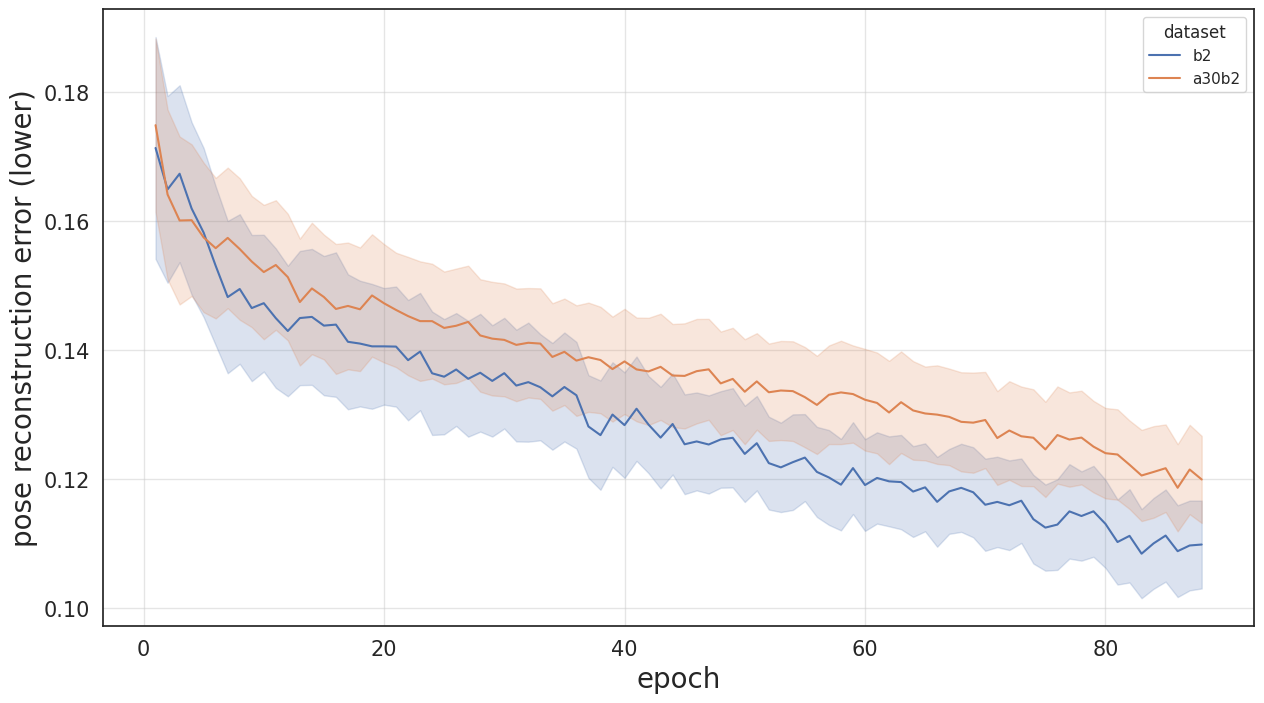

In [48]:
fig = plt.figure(figsize=(1280*plt_px,720*plt_px))
ax = sns.lineplot(data=df[df.part == 'lower'],x='epoch',y='rec',hue='dataset',errorbar='sd')
plt.xlabel('epoch',fontsize=20)
plt.ylabel('pose reconstruction error (lower)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(alpha=0.5)
plt.tight_layout()

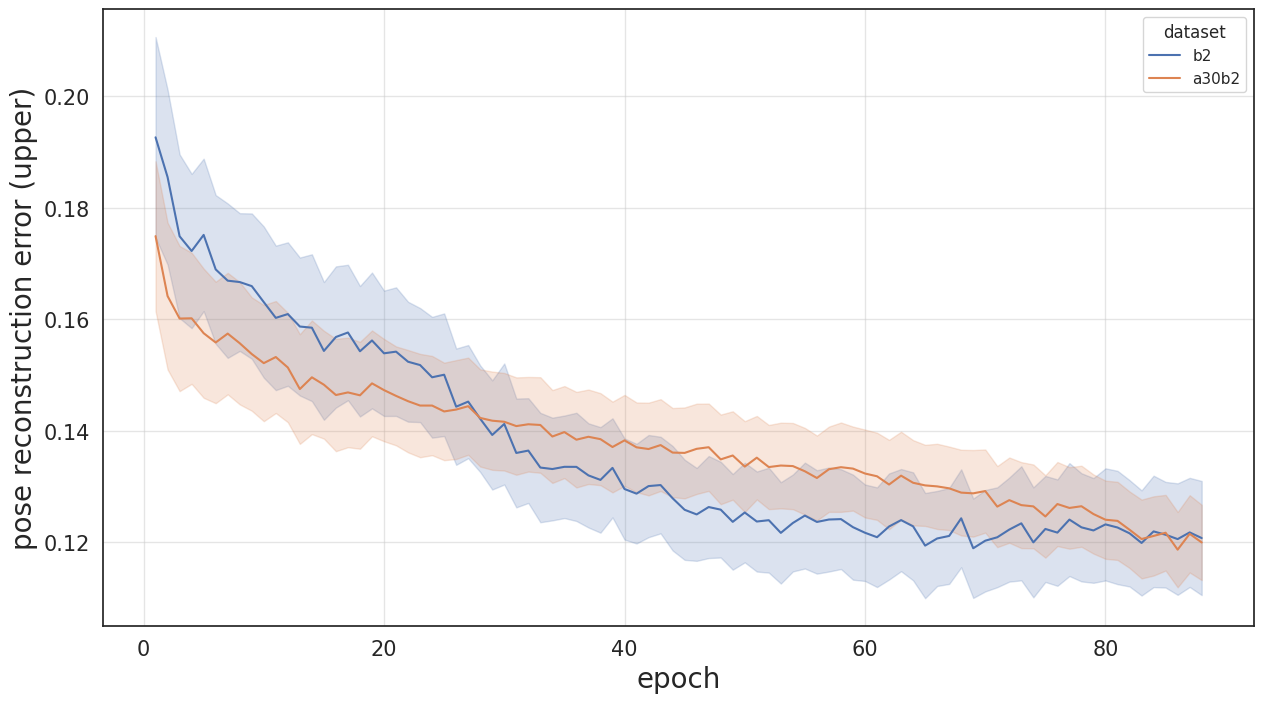

In [49]:
fig = plt.figure(figsize=(1280*plt_px,720*plt_px))
ax = sns.lineplot(data=df[df.part == 'upper'],x='epoch',y='rec',hue='dataset',errorbar='sd')
plt.xlabel('epoch',fontsize=20)
plt.ylabel('pose reconstruction error (upper)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(alpha=0.5)
plt.tight_layout()

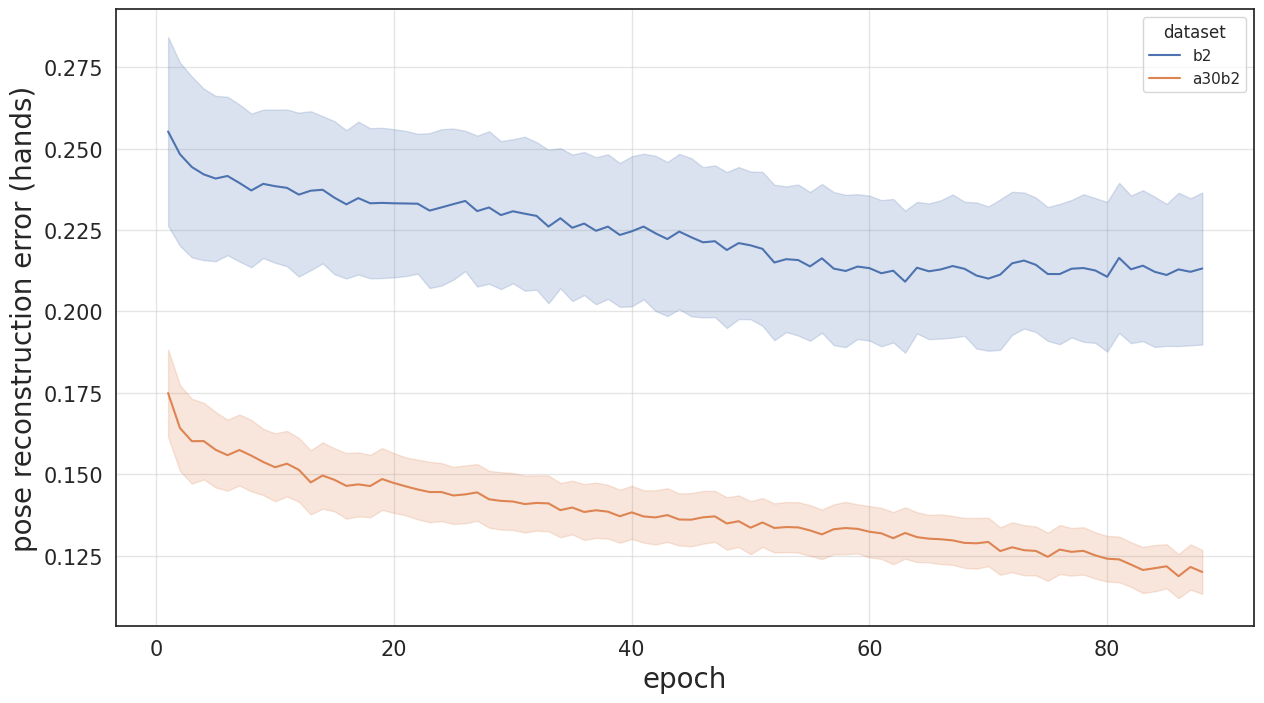

In [50]:
fig = plt.figure(figsize=(1280*plt_px,720*plt_px))
ax = sns.lineplot(data=df[df.part == 'hands'],x='epoch',y='rec',hue='dataset',errorbar='sd')
plt.xlabel('epoch',fontsize=20)
plt.ylabel('pose reconstruction error (hands)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(alpha=0.5)
plt.tight_layout()

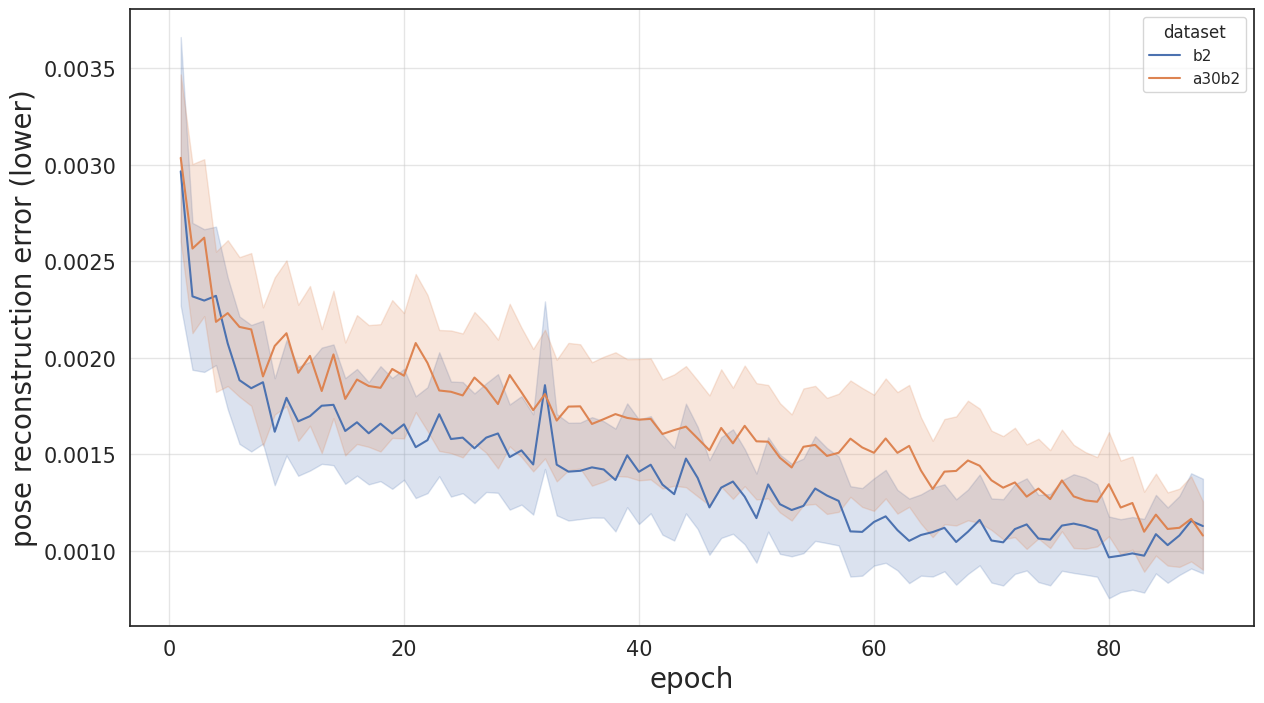

In [51]:
fig = plt.figure(figsize=(1280*plt_px,720*plt_px))
ax = sns.lineplot(data=df[df.part == 'lower'],x='epoch',y='ver',hue='dataset',errorbar='sd')
plt.xlabel('epoch',fontsize=20)
plt.ylabel('pose reconstruction error (lower)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(alpha=0.5)
plt.tight_layout()

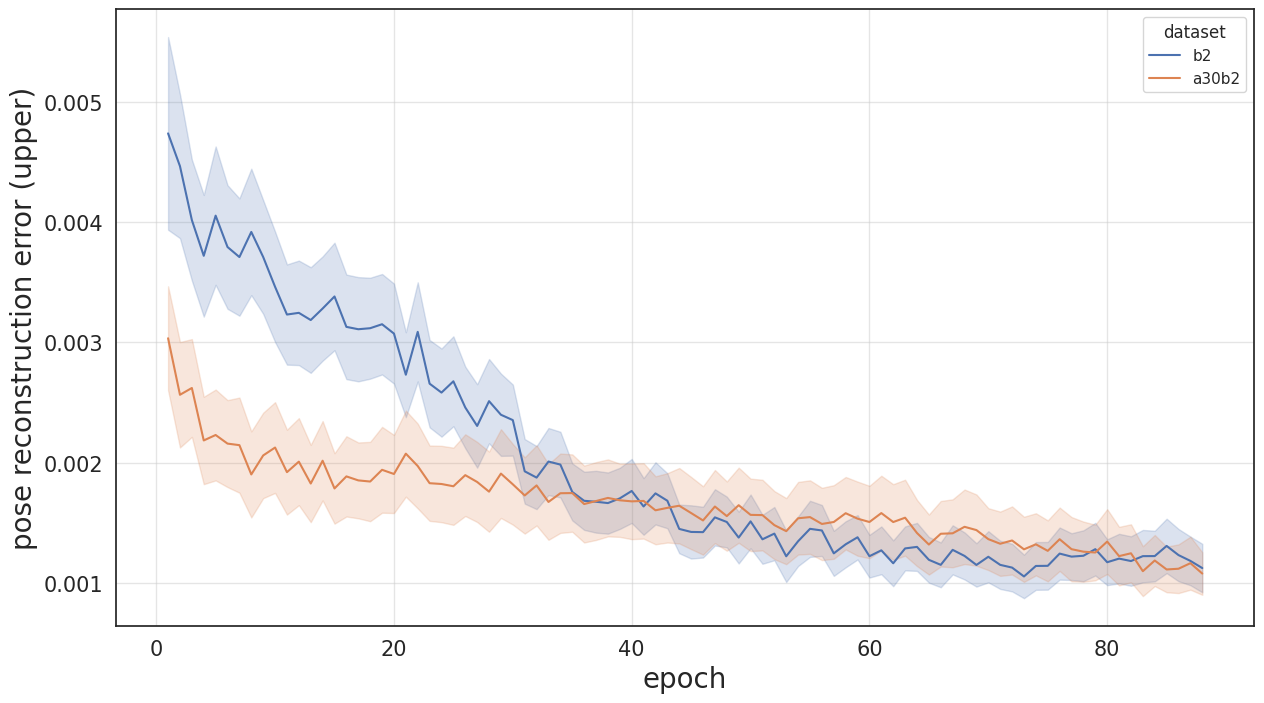

In [52]:
fig = plt.figure(figsize=(1280*plt_px,720*plt_px))
ax = sns.lineplot(data=df[df.part == 'upper'],x='epoch',y='ver',hue='dataset',errorbar='sd')
plt.xlabel('epoch',fontsize=20)
plt.ylabel('pose reconstruction error (upper)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(alpha=0.5)
plt.tight_layout()

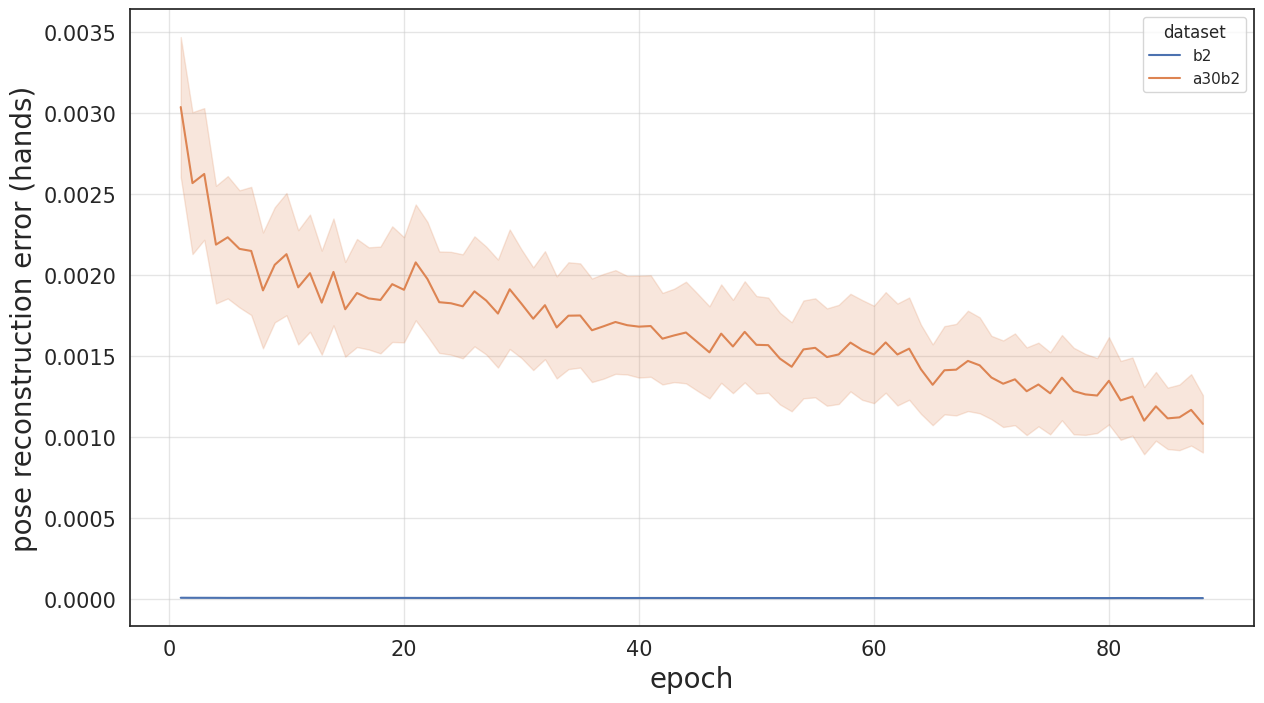

In [53]:
fig = plt.figure(figsize=(1280*plt_px,720*plt_px))
ax = sns.lineplot(data=df[df.part == 'hands'],x='epoch',y='ver',hue='dataset',errorbar='sd')
plt.xlabel('epoch',fontsize=20)
plt.ylabel('pose reconstruction error (hands)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(alpha=0.5)
plt.tight_layout()

# train/test split based on speakers

In [1]:
import csv
import os
import pathlib


from natsort import natsorted,natsort_keygen
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


sns.set(font_scale=2)
sns.set_theme(style='white')
plt_px = 1/plt.rcParams['figure.dpi']

beat_d = pathlib.Path('/vision/changan/shrinidhi/data2/beat_v2.0.0')

In [2]:
data_fs = [f
           for lang_d in beat_d.iterdir()
           for f in (lang_d / 'smplxflame_30').iterdir()
           if f.suffix == '.npz']
print('num examples:',len(data_fs))

num examples: 2048


In [3]:
sp_id,fs,n_frames = list(),list(),list()
for f in tqdm(data_fs,ncols=150):
    id,name = f.name.split('_')[:2]
    sp_id.append(f'{id}_{name}')
    fs.append(f.name)
    data = np.load(f,allow_pickle=True)
    n_frames.append(data['poses'].shape[0])

df = pd.DataFrame({'sp_id':sp_id,
                   'f':fs,
                   'n':n_frames})
df = df.sort_values(by='sp_id',key=natsort_keygen())
df.head()

  0%|                                                                                                                        | 0/2048 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:57<00:00, 17.43it/s]


,sp_id,f,n
798,1_wayne,1_wayne_1_9_9.npz,17994
765,1_wayne,1_wayne_0_80_80.npz,1763
766,1_wayne,1_wayne_0_81_81.npz,2394
767,1_wayne,1_wayne_0_82_82.npz,2184
768,1_wayne,1_wayne_0_83_83.npz,1404


In [4]:
print('num speakers:',len(df.sp_id.unique()))

num speakers: 25


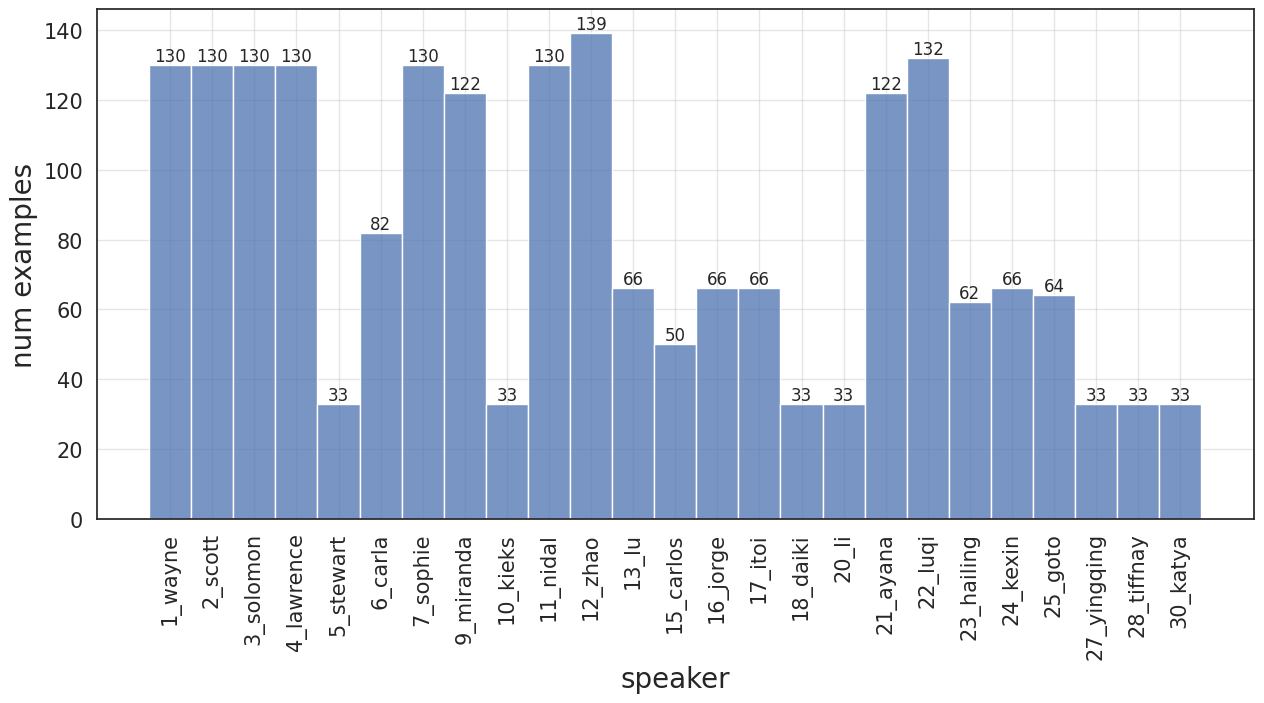

In [22]:
fig = plt.figure(figsize=(1280*plt_px,720*plt_px))
ax = sns.histplot(data=df,x='sp_id',stat='count')
ax.bar_label(ax.containers[0])
plt.xlabel('speaker',fontsize=20)
plt.ylabel('num examples',fontsize=20)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.grid(alpha=0.5)
plt.tight_layout()

In [5]:
df_plot = df[['sp_id','n']].groupby('sp_id').sum()
df_plot = df_plot.reset_index()
df_plot = df_plot.sort_values(by='sp_id',key=natsort_keygen())
df_plot['hrs'] = (df_plot.n / 30) / (60*60)
df_plot.head()

,sp_id,n,hrs
8,1_wayne,429305,3.975046
17,2_scott,410725,3.803009
19,3_solomon,453273,4.196972
20,4_lawrence,469063,4.343176
21,5_stewart,112477,1.041454


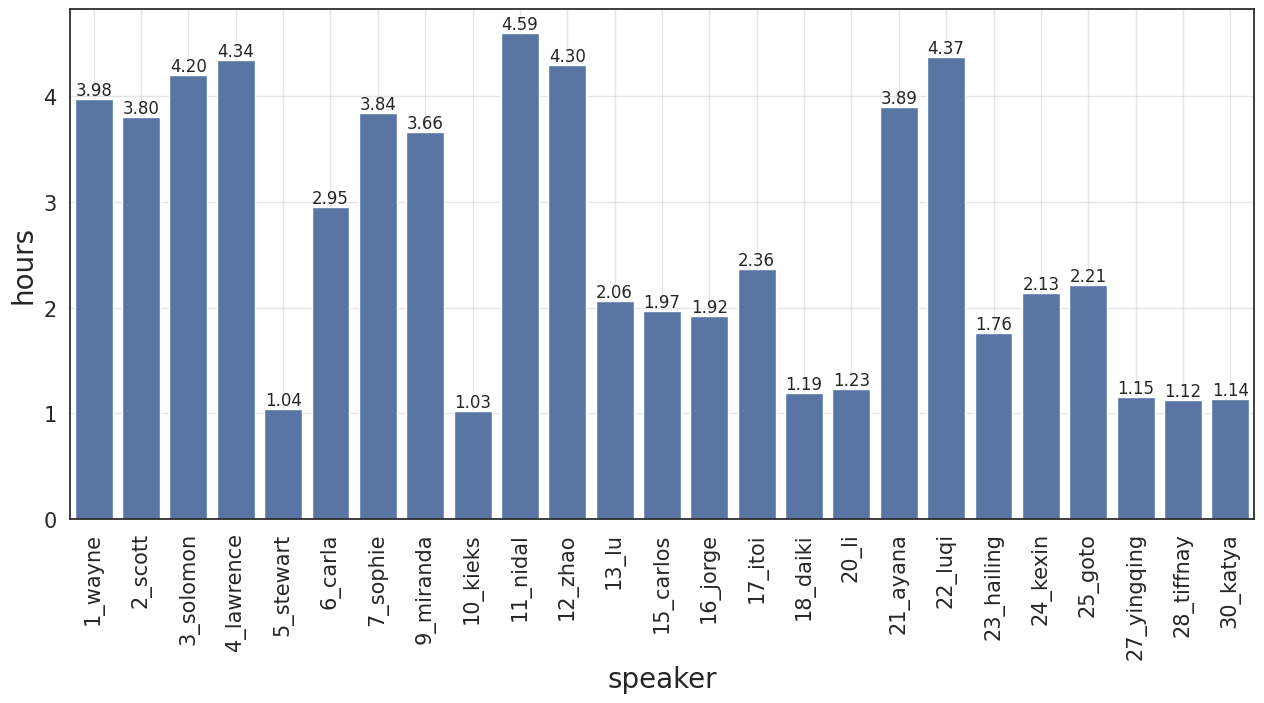

In [14]:
fig = plt.figure(figsize=(1280*plt_px,720*plt_px))
ax = sns.barplot(data=df_plot,x='sp_id',y='hrs',)
ax.bar_label(ax.containers[0],fmt='%.2f')
plt.xlabel('speaker',fontsize=20)
plt.ylabel('hours',fontsize=20)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [6]:
df.sp_id.unique()

array(['1_wayne', '2_scott', '3_solomon', '4_lawrence', '5_stewart',
       '6_carla', '7_sophie', '9_miranda', '10_kieks', '11_nidal',
       '12_zhao', '13_lu', '15_carlos', '16_jorge', '17_itoi', '18_daiki',
       '20_li', '21_ayana', '22_luqi', '23_hailing', '24_kexin',
       '25_goto', '27_yingqing', '28_tiffnay', '30_katya'], dtype=object)

In [9]:
emage_beat2_sp_split_d = pathlib.Path('/vision/vision_data_2/VGGSound_shards_fixed/shrinidhi/emage_beat2ss')
train_test_f = emage_beat2_sp_split_d / 'train_test_split.csv'

In [10]:
data_fs = list((emage_beat2_sp_split_d / 'smplxflame_30').iterdir())
data_fs.sort()
print('num examples:',len(data_fs))

num examples: 2048


Test set will contain 2 speakers -- `2_scott` and `7_sophie`.

In [11]:
test_fs = {f
           for f in data_fs 
           if ('2_scott' in f.name or
               '7_sophie' in f.name)}
train_fs = {f
            for f in data_fs
            if f not in test_fs}

print(len(train_fs),len(test_fs))

1788 260


In [12]:
rows = [{'id':f.with_suffix('').name,
         'type':'test'}
        for f in test_fs]
rows += [{'id':f.with_suffix('').name,
          'type':'test'}
         for f in train_fs]
rows += [{'id':f.with_suffix('').name,
          'type':'val'}
         for f in test_fs]
rows += [{'id':f.with_suffix('').name,
         'type':'train'}
         for f in train_fs]

with open(train_test_f,'w') as csv_f:
        writer = csv.DictWriter(csv_f,
                                fieldnames=['id','type'])
        writer.writeheader()
        writer.writerows(rows)

In [13]:
df = pd.read_csv(train_test_f)
print(df.shape)
df.head()

(4096, 2)


,id,type
0,beat_english_v2.0.0__smplxflame_30__2_scott_0_...,test
1,beat_english_v2.0.0__smplxflame_30__2_scott_0_...,test
2,beat_english_v2.0.0__smplxflame_30__2_scott_0_...,test
3,beat_english_v2.0.0__smplxflame_30__2_scott_0_...,test
4,beat_english_v2.0.0__smplxflame_30__2_scott_0_...,test


#### New Dataset with AMASS and BEAT2 speaker split

In [1]:
from collections import defaultdict
import csv
import pathlib

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
data_d = pathlib.Path('/vision/vision_data_2/VGGSound_shards_fixed/shrinidhi/emage_amass30_beat2ss')
amass_d = pathlib.Path('/vision/vision_data_2/VGGSound_shards_fixed/shrinidhi/amass_smplx_beat2_aligned_from_juze')
train_test_f = data_d / 'train_test_split.csv'

In [ ]:
data_fs = list(amass_d.iterdir())
print('num amass examples:',len(data_fs))

num amass examples: 20726


In [4]:
amass_data_fs = list()
files_not_readable = list()
files_model_type_not_usable = list()
files_mocap_frame_rate_key_missing = list()
files_frame_rate_not_multiple_of_30 = list()
all_model_types = defaultdict(int)
all_fps = defaultdict(int)
for f in tqdm(data_fs,desc='filtering 30fps files'):
    try:
        data = np.load(f,allow_pickle=True)
    except zipfile.BadZipFile:
        files_not_readable.append(f)
        continue
    all_model_types[data['surface_model_type'].item()] += 1
    if data['surface_model_type'].item() not in {'smplx','smplx_locked_head'}:
        files_model_type_not_usable.append(f)
        continue
    if 'mocap_frame_rate' not in data:
        files_mocap_frame_rate_key_missing.append(f)
        continue
    fps = int(data['mocap_frame_rate'].item())
    all_fps[fps] += 1
    if fps % 30 != 0:
        files_frame_rate_not_multiple_of_30.append(f)
        continue
    amass_data_fs.append(f)
print('total files:',len(data_fs))
print('usable_files:',len(amass_data_fs))
print('files not readable:',len(files_not_readable))
print('files model type not usable:',len(files_model_type_not_usable))
print('files missing mocap_frame_rate:',len(files_mocap_frame_rate_key_missing))
print('files with frame rante not multiple of 30fps:',len(files_frame_rate_not_multiple_of_30))
print('model types:',*sorted(all_model_types.items()))
print('mocap frame rate:',*sorted(all_fps.items()))
assert len(data_fs) == (len(amass_data_fs) + 
                        len(files_not_readable) + 
                        len(files_model_type_not_usable) + 
                        len(files_mocap_frame_rate_key_missing) + 
                        len(files_frame_rate_not_multiple_of_30))

filtering 30fps files:   0%|          | 0/20726 [00:00<?, ?it/s]

total files: 20726
usable_files: 11352
files not readable: 0
files model type not usable: 0
files missing mocap_frame_rate: 0
files with frame rante not multiple of 30fps: 9374
model types: ('smplx', 20726)
mocap frame rate: (59, 26) (60, 1064) (100, 9234) (120, 10288) (250, 114)


In [5]:
for src_f in tqdm(amass_data_fs,desc='creating symlinks'):
    dst_f = data_d / 'smplxflame_30' / str(src_f.relative_to(amass_d)).replace('/','__')
    dst_f.symlink_to(src_f)

creating symlinks:   0%|          | 0/11352 [00:00<?, ?it/s]

In [6]:
data_fs = list((data_d / 'smplxflame_30').iterdir())
data_fs.sort()
print('num examples:',len(data_fs))

num examples: 13400


Test set will contain 2 speakers -- `2_scott` and `21_ayana`.

In [7]:
test_fs = {f
           for f in data_fs 
           if ('2_scott' in f.name or
               '21_ayana' in f.name)}
train_fs = {f
            for f in data_fs
            if f not in test_fs}

print(len(train_fs),len(test_fs))

13148 252


In [8]:
rows = [{'id':f.with_suffix('').name,
         'type':'test'}
        for f in test_fs]
# rows += [{'id':f.with_suffix('').name,
#           'type':'test'}
#          for f in train_fs]
rows += [{'id':f.with_suffix('').name,
          'type':'val'}
         for f in test_fs]
rows += [{'id':f.with_suffix('').name,
         'type':'train'}
         for f in train_fs]

with open(train_test_f,'w') as csv_f:
        writer = csv.DictWriter(csv_f,
                                fieldnames=['id','type'])
        writer.writeheader()
        writer.writerows(rows)

In [9]:
df = pd.read_csv(train_test_f)
df

,id,type
0,beat_english_v2.0.0__smplxflame_30__21_ayana_0...,test
1,beat_english_v2.0.0__smplxflame_30__21_ayana_0...,test
2,beat_english_v2.0.0__smplxflame_30__2_scott_0_...,test
3,beat_english_v2.0.0__smplxflame_30__2_scott_0_...,test
4,beat_english_v2.0.0__smplxflame_30__21_ayana_0...,test
...,...,...
13647,002556,train
13648,009361,train
13649,005100,train
13650,beat_english_v2.0.0__smplxflame_30__7_sophie_0...,train
